# Analyzing missing data in Python Statsmodels, a case study with the NHANES data

This notebook demonstrates several techniques for working with
missing data in Python, using the Statsmodels library.  The methods
are illustrated using data from the
NHANES (National Health and Nutrition Examination Study).

First we import the libraries that we will be using.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import statsmodels.api as sm
import numpy as np
from statsmodels.imputation import mice
from statsmodels.imputation.bayes_mi import BayesGaussMI, MI

/nfs/kshedden/python3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


Next we will load the data.  The NHANES study encompasses multiple
waves of data collection.  Here we will only use the 2015-2016 data.

In [2]:
url = "https://raw.githubusercontent.com/kshedden/statswpy/master/NHANES/merged/nhanes_2015_2016.csv"
da = pd.read_csv(url)

# Retain a subset of columns for use below.
vars = ["BPXSY1", "RIDAGEYR", "RIAGENDR", "RIDRETH1", "DMDEDUC2", "BMXBMI", "SMQ020"]

# Multiple imputation

Here we demonstrate how to use multiple imputation to estimate a
correlation coefficient when some data values are missing.  Blood
pressure and BMI are expected to be positively related, and we
estimate the correlation between them below.  A thorough understanding
of the relationship between blood pressure and BMI should consider
gender, BMI, and other possibly relevant factors.  But for illustration,
we focus here on the simple unadjusted correlation.

In the next cell, we determine how many values of these variables are missing:

In [3]:
dx = da.loc[:, ["BPXSY1", "BMXBMI"]]

# Size of all data, including missing values
print(dx.shape)

# Number of missing values for each variable
print(pd.isnull(dx).sum(0))

# Number of cases that are missing both variables
print(pd.isnull(dx).prod(1).sum(0))

(5735, 2)
BPXSY1    334
BMXBMI     73
dtype: int64
19


Next, for comparison purposes, we estimate the correlation
coefficient and its standard error using "complete case" analysis:

In [4]:
dd = dx.dropna()
c = np.cov(dd.T)

r_cc = c[0, 1] / np.sqrt(c[0, 0] * c[1, 1])
print("Complete case estimate:       %f" % r_cc)
print("Complete case standard error: %f\n" % (1 / np.sqrt(dd.shape[0])))

Complete case estimate:       0.135201
Complete case standard error: 0.013676



Now we are ready to use multiple imputation.  Statsmodels provides a
Bayesian imputation framework using the Gaussian distribution (we
will explore other ways to do imputation later).

Like most Bayesian methods, this approach utilizes prior
distributions on the structural parameters of the model.  If the
data are approximately standardized (i.e. have zero mean and unit
variance), then the default priors should work fine.  But BMI and
blood pressure are measured on scales with values ranging from
around 10 to 200.  Therefore, we scale the prior covariance matrices
accordingly.

To use this approach, we first construct an imputation object and
"burn" it in.

In [5]:
bm = BayesGaussMI(dx, mean_prior=100*np.eye(2), cov_prior=100*np.eye(2))

for k in range(100):
    bm.update()

Now we are ready to draw samples from the imputation object, and use
these samples to estimate the unknown parameter of interest (the correlation
between blood pressure and BMI).

In [6]:
rv = []
for k in range(200):
    bm.update()

    # After calling bm.update, we can access bm.mean and bm.cov,
    # which are draws from the posterior distribution of the
    # Gaussian mean and covariance parameters given the data.
    # We can also access the underlying data frame dx, which
    # has now been imputed so that there are no missing values.
    r = bm.cov[0, 1] / np.sqrt(bm.cov[0, 0] * bm.cov[1, 1])

    rv.append(r)

rv = np.asarray(rv)

Based on these posterior samples, we can estimate the posterior mean and
posterior variance of the correlation coefficient between BMI and
blood pressure.

In [7]:
print("Mean: ", rv.mean())
print("SD:   ", rv.std())

Mean:  0.13646846202360918
SD:    0.013897382582866182


We can also view the histogram of the draws from the posterior
distribution.

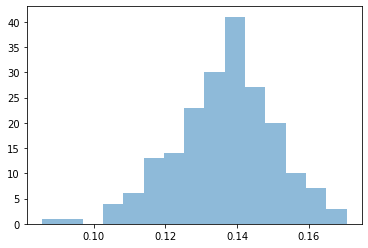

In [8]:
_ = plt.hist(rv, bins=15, alpha=0.5)

# Simulation study to assess "information" in partially observed records

Next we use a small simulation study to better understand the
performance characteristics of this type of multiple imputation.  We
take the NHANES data for BMI and blood and introduce increasingly
greater fractions of missing values into the data.  Then we use
multiple imputation (MI) and complete case analysis to estimate the
correlation coefficient between blood pressure and BMI, and the
standard error of this statistic.

In [9]:
for f in 0.2, 0.4, 0.6:

    # Introduce missing values, at rate equal to f.
	dy = dx.copy()
	for j in 0, 1:
		ii = np.flatnonzero(np.random.uniform(size=dy.shape[0]) < f)
		dy.iloc[ii, j] = np.nan

	# Complete cases
	dc = dy.dropna()

    # Set up an imputer
	bm = BayesGaussMI(dy, mean_prior=100*np.eye(2), cov_prior=100*np.eye(2))

    # Burn in the imputer
	for k in range(100):
	    bm.update()

    # Generate 200 samples from the posterior distribution of the
    # covariance matrix
	rv = []
	for k in range(200):
	    bm.update()
	    r = bm.cov[0, 1] / np.sqrt(bm.cov[0, 0] * bm.cov[1, 1])
	    rv.append(r)
	rv = np.asarray(rv)

    # The mean and standard deviation based on the multiply
    # imputed data, and the standard deviation for complete
    # case analysis (which is computed theoretically as
    # 1/sqrt(sample size)).
	print(rv.mean(), rv.std(), 1/np.sqrt(dc.shape[0]))

0.1294361670803976 0.016092986661808424 0.016534008228581126


0.1435750916781924 0.020289440775454495 0.022107884414269093


0.15221923818886549 0.03388342050090585 0.032879797461071454


Next we have a modified version of the simulation above.  We
introduce missing values into BMI and SBP, and then
impute the missing values multiple times.  We then take the mean of log transformed
BMI for each dataset, and the sampling variance of this
quantity.  Finally, we use the combining rules to produce
an estimate of the overall uncertainty in the estimate of
the expected value of log BMI.  Since we are imputing BMI,
but analyzing log BMI, we cannot simply use the covariance
matrix from the MI procedure, as in the example above.

In [10]:
for f in 0.2, 0.4, 0.6:

    # Introduce missing values, at rate equal to f.
	dy = dx.copy()
	for j in 0, 1:
		ii = np.flatnonzero(np.random.uniform(size=dy.shape[0]) < f)
		dy.iloc[ii, j] = np.nan

    # Set up an imputer
	bm = BayesGaussMI(dy, mean_prior=100*np.eye(2), cov_prior=100*np.eye(2))

    # Burn in the imputer
	for k in range(100):
	    bm.update()

    # Generate 200 samples from the posterior distribution of the
    # covariance matrix
	lm = []
	for k in range(200):
	    bm.update()
	    lbmi = np.log(bm.data.BMXBMI)
	    lm.append([lbmi.mean(), lbmi.var()/len(lbmi)])
	lm = np.asarray(lm)

	print(lm[:, 0].mean(), np.sqrt(lm[:, 1].mean() + lm[:, 0].var()))

/nfs/kshedden/python3/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


3.3536019378556396 0.0036617845448228474


3.3536123951751136 0.004235657494170672


3.3426949926268628 0.005606378154698827


The goal of any imputation analysis is to recover information from
"partially observed" cases.  Here, a partially observed case is a
person for whom either the blood pressure or BMI value (but not
both) is missing.  Depending on the specific statistic that is being
calculated (or model that is being fit), the benefit of recovering
information from partially observed observations can be substantial,
or quite small.

Since the missing data values are introduced into random locations,
and the MI procedure is itself stochastic, the results of this
simulation study will vary from run to run.  In general, the
complete case standard error and MI "standard error" (which is
actually a posterior standard deviation) are quite similar, but the
complete case standard error tends to be the slightly larger of the
two.  In this setting, the observations with only one value
contribute to the MI analysis but not to the complete case analysis.
It turns out that retaining these cases only provides a small amount
of information that is relevant for estimating the correlation
coefficient.

# Multiple imputation for regression

The MI class can automate the process of applying multiple
imputation to a dataset and using the "combining rules" to produce a
single set of parameter estimates and standard errors.  We will
illustrate this for the task of using linear regression to explore
the conditional relationship of blood pressure given BMI, age, and
gender.

First, we subset the data that we will be using.

In [11]:
dx = da.loc[:, ["BPXSY1", "BMXBMI", "RIDAGEYR", "RIAGENDR"]]

print(dx.shape)
print(pd.isnull(dx).sum(0))

(5735, 4)
BPXSY1      334
BMXBMI       73
RIDAGEYR      0
RIAGENDR      0
dtype: int64


Only a handful of values are missing, so for illustration purposes,
we introduce additional missing values into the age and BMI
variables.

In [12]:
ii = np.flatnonzero(np.random.uniform(size=dx.shape[0]) < 0.1)
dx.loc[ii, "RIDAGEYR"] = np.nan

ii = np.random.uniform(size=dx.shape[0]) < 0.1
dx.loc[ii, "BMXBMI"] = np.nan

print(pd.isnull(dx).sum(0))

BPXSY1      334
BMXBMI      603
RIDAGEYR    588
RIAGENDR      0
dtype: int64


Now we are ready to go:

In [13]:
v = np.r_[100, 30, 40, 1]
bm = BayesGaussMI(dx, mean_prior=np.diag(v), cov_prior=np.diag(v))

def model_kwds_fn(x):
    return {"data": x}

mi = MI(bm, sm.OLS, formula="BPXSY1 ~ BMXBMI + RIDAGEYR + RIAGENDR",
        burn=0, model_kwds_fn=model_kwds_fn)
mir = mi.fit()

print(mir.summary())

                 Results: Ordinary least squares
Method:                    MI          Sample size:          5735
Model:                     OLS         Num. imputations      20  
Dependent variable:        BPXSY1                                
-----------------------------------------------------------------
           Coef.  Std.Err.    t    P>|t|   [0.025  0.975]   FMI  
-----------------------------------------------------------------
Intercept 99.8122   1.3192 75.6611 0.0000 97.2266 102.3977 0.1679
BMXBMI     0.3062   0.0348  8.7974 0.0000  0.2379   0.3744 0.2323
RIDAGEYR   0.4557   0.0125 36.5261 0.0000  0.4313   0.4802 0.1285
RIAGENDR  -3.7659   0.4494 -8.3804 0.0000 -4.6467  -2.8852 0.0913



Note that the multiple imputation results show the full sample size,
indicating that no cases were dropped (as in a complete case
analysis).

# MICE

Multiple Imputation with Chained Equations (MICE) is a
regression-based framework for imputing missing values that allows
us to specify arbitrary regression models for imputing each
variable's missing values from the other variables.

One common workflow with MICE is to create a set of imputed
datasets, then save them as files.  They can then be retrieved later
and used in an MI analysis using the "combining rules".  This
workflow is illustrated below.

In [14]:
dx = da.copy()
dx = dx.loc[:, ["BMXBMI", "BPXSY1", "RIAGENDR", "RIDAGEYR"]]

# Recode to 0 (male), 1 (female)
dx.RIAGENDR -= 1

# Introduce some missing values
for k in range(dx.shape[1]):
    ii = np.flatnonzero(np.random.uniform(size=dx.shape[0]) < 0.1)
    dx.iloc[ii, k] = np.nan

imp_data = mice.MICEData(dx)
imp_data.set_imputer("BMXBMI", "RIDAGEYR + RIAGENDR")
imp_data.set_imputer("RIAGENDR", "BPXSY1 + RIDAGEYR + BMXBMI", model_class=sm.GLM,
                     init_kwds={"family": sm.families.Binomial()})

for j in range(10):
    imp_data.update_all()

    # Uncomment this line to save the files.
    #imp_data.to_csv('data%02d.csv' % j)

Another common workflow is to combine the data imputation, modeling
and results combination together.

In [15]:
dx = da.copy()
dx = dx.loc[:, ["BMXBMI", "BPXSY1", "RIAGENDR", "RIDAGEYR"]]

# Recode to 0 (male), 1 (female)
dx.RIAGENDR -= 1

# Introduce some missing values
for k in range(dx.shape[1]):
    ii = np.flatnonzero(np.random.uniform(size=dx.shape[0]) < 0.1)
    dx.iloc[ii, k] = np.nan

imp_data = mice.MICEData(dx)
imp_data.set_imputer("BMXBMI", "RIDAGEYR + RIAGENDR")
imp_data.set_imputer("RIAGENDR", "BPXSY1 + RIDAGEYR + BMXBMI", model_class=sm.GLM,
                     init_kwds={"families": sm.families.Binomial()})

mi = mice.MICE("BPXSY1 ~ RIDAGEYR + RIAGENDR + BMXBMI", sm.OLS, imp_data, n_skip=1)
result = mi.fit(10, 10)

print(result.summary())

                         Results: MICE
Method:                   MICE       Sample size:         5734  
Model:                    OLS        Scale                258.93
Dependent variable:       BPXSY1     Num. imputations     10    
----------------------------------------------------------------
           Coef.  Std.Err.    t    P>|t|   [0.025  0.975]  FMI  
----------------------------------------------------------------
Intercept 96.5985   1.1731 82.3454 0.0000 94.2992 98.8977 0.2068
RIDAGEYR   0.4673   0.0133 35.1179 0.0000  0.4412  0.4934 0.2507
RIAGENDR  -3.7378   0.5062 -7.3842 0.0000 -4.7299 -2.7457 0.2880
BMXBMI     0.2682   0.0363  7.3813 0.0000  0.1970  0.3395 0.3235

